In [23]:
# EDUFACE - Facial Recognition Attendance System
# Integrated with LMS for student attendance recording
# Date: October 25, 2025

# ================================================
# 1. INSTALLING DEPENDENCIES
# ================================================
# Install required packages
!pip install tensorflow opencv-python matplotlib
!pip install seaborn
!pip install scikit-learn



# ================================================
# 2. IMPORTING DEPENDENCIES
# ================================================
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# TensorFlow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall




[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ================================================
# 3. SET GPU MEMORY GROWTH
# ================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Number of GPUs available:", len(gpus))
else:
    print("No GPUs detected. Running on CPU.")


No GPUs detected. Running on CPU.


In [24]:

# ================================================
# 4. SETTING UP FOLDER STRUCTURE
# ================================================
# Define base paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# Create directories
POS_PATH = os.path.join(DATA_PATH, 'positive')
NEG_PATH = os.path.join(DATA_PATH, 'negative')
ANC_PATH = os.path.join(DATA_PATH, 'anchor')

os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_PATH}")
print(f"   Negative: {NEG_PATH}")
print(f"   Anchor: {ANC_PATH}")



✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor


In [22]:
# ================================================
# 5. EXTRACT LFW DATASET FOR NEGATIVES
# ================================================
import tarfile
import glob

# Path to LFW .tgz file
tgz_path = os.path.join(BASE_PATH, 'lfw-funneled.tgz')
extract_path = NEG_PATH

# Validate and extract
if os.path.isfile(tgz_path):
    print(f"Found .tgz file at: {tgz_path}")
    os.makedirs(extract_path, exist_ok=True)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted successfully!")
    
    # Find LFW root
    possible_roots = [
        os.path.join(extract_path, "lfw_funneled"),
        os.path.join(extract_path, "lfw-funneled"),
        os.path.join(extract_path, "lfw"),
    ]
    lfw_root = next((root for root in possible_roots if os.path.exists(root)), None)
    
    if lfw_root:
        print(f"✅ LFW dataset at: {lfw_root}")
        # Move images to negative folder (flatten structure)
        for person_dir in os.listdir(lfw_root):
            person_path = os.path.join(lfw_root, person_dir)
            if os.path.isdir(person_path):
                for img_file in os.listdir(person_path):
                    src = os.path.join(person_path, img_file)
                    dst = os.path.join(NEG_PATH, img_file)
                    if os.path.exists(dst):
                        os.remove(dst)  # Overwrite duplicates
                    os.rename(src, dst)
        # Clean up empty dirs (note: may need to remove lfw_root if empty)
        print("✅ Negatives moved and structure flattened.")
    else:
        print("⚠️ Could not find LFW root. Check extraction.")
else:
    print("⚠️ LFW .tgz not found. Download from http://vis-www.cs.umass.edu/lfw/")




Found .tgz file at: C:\Projects\EDUFACE PROJECT\lfw-funneled.tgz
✅ Dataset extracted successfully!
✅ LFW dataset at: C:\Projects\EDUFACE PROJECT\data\negative\lfw_funneled
✅ Negatives moved and structure flattened.


In [25]:
# ================================================
# 6. COLLECT POSITIVES AND ANCHORS
# ================================================
# Advanced multi-angle face capture with student info
import time
import uuid
import platform
import glob

def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# Get student details
student_name = input("Enter student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')

print(f"\n📁 Saving images for {student_name}_{student_id}")
print(f"   Anchor: {ANC_PATH}")
print(f"   Positive: {POS_PATH}")

# Initialize counters
def get_next_count(folder_path, prefix):
    existing = glob.glob(os.path.join(folder_path, f"{prefix}_*.jpg"))
    if existing:
        counts = [int(os.path.basename(f).split('_')[2]) for f in existing if len(os.path.basename(f).split('_')) > 2 and os.path.basename(f).split('_')[2].isdigit()]
        return max(counts) + 1 if counts else 1
    return 1

anchor_count = get_next_count(ANC_PATH, f"{student_name}_{student_id}")
positive_count = get_next_count(POS_PATH, f"{student_name}_{student_id}")

# Load Haar Cascades for multi-angle detection
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            # Calculate IoU
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                # Keep larger face
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Initialize capture
cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found.")

capture_type = "positive"
is_capturing = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0))
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        status = f"Mode: {capture_type.upper()} | Faces: {len(faces)} | {'CAPTURING' if is_capturing else 'PAUSED'}"
        cv2.putText(frame, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        count_text = f"Anchor: {anchor_count-1} | Positive: {positive_count-1}"
        cv2.putText(frame, count_text, (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        cv2.imshow("EDUFACE Capture - 'a' anchor, 'p' positive, 'c' hold to capture, 'q' quit", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('a'):
            capture_type = 'anchor'
            print("🔄 ANCHOR mode")
        elif key == ord('p'):
            capture_type = 'positive'
            print("🔄 POSITIVE mode")
        elif key == ord('c'):
            is_capturing = not is_capturing  # Toggle
            print(f"{'Start' if is_capturing else 'Stop'} capturing")
        elif key == ord('q'):
            break

        if is_capturing and faces:
            folder = ANC_PATH if capture_type == 'anchor' else POS_PATH
            count = anchor_count if capture_type == 'anchor' else positive_count
            prefix = f"{student_name}_{student_id}"
            
            for i, (x,y,w,h) in enumerate(faces):
                face_crop = frame[y:y+h, x:x+w]
                ft = face_types[i] if i < len(face_types) else 'frontal'
                angle = ft.replace('frontal','front').replace('_alt','').replace('_alt2','')
                unique_id = str(uuid.uuid4())[:8]
                filename = os.path.join(folder, f"{prefix}_{angle}_{count}_{unique_id}.jpg")
                resized = cv2.resize(face_crop, (250, 250))  # Capture at 250x250
                cv2.imwrite(filename, resized)
                print(f"✅ Saved {os.path.basename(filename)} ({ft}, {capture_type})")
                
                if capture_type == 'anchor':
                    anchor_count += 1
                else:
                    positive_count += 1
            
            time.sleep(0.2)  # Rate limit

finally:
    cap.release()
    cv2.destroyAllWindows()

# Dataset summary
total_anchor = len(glob.glob(os.path.join(ANC_PATH, "*.jpg")))
total_positive = len(glob.glob(os.path.join(POS_PATH, "*.jpg")))
total_negative = len(glob.glob(os.path.join(NEG_PATH, "*.jpg")))

print(f"\n📊 Dataset Summary:")
print(f"   Anchor: {total_anchor}")
print(f"   Positive: {total_positive}")
print(f"   Negative: {total_negative}")

if total_anchor < 10 or total_positive < 10:
    print("⚠️ WARNING: Collect more images (10+ per class) for better performance.")



📁 Saving images for _
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade

📊 Dataset Summary:
   Anchor: 2845
   Positive: 2673
   Negative: 13966


Raw counts: Anchor=2845, Positive=2671, Negative=13966

🔍 Testing filename parser on samples:
  Bahati_Jere_150166_front2_108_e207b004.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_116_25685cfa.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_118_98eeaa79.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_103_ffa1ccbd.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_104_42bbb890.jpg... → Bahati_Jere
  Bahati_Jere_150166_front2_108_067c3cc8.jpg... → Bahati_Jere

📊 Found 1 unique student prefixes in samples

📂 Grouping results:
   Students in anchors: 12
   Students in positives: 12

👥 Sample student image counts:
   1. Bahati_Jere: 268 anchors, 283 positives
   2. Benjamin_151541: 175 anchors, 197 positives
   3. Elvis_151343: 105 anchors, 224 positives
   4. Latasha_Kariuki: 150 anchors, 185 positives
   5. Leila_131456: 192 anchors, 174 positives

✅ Valid students with ≥1 images each: 12
   Valid students: ['Bahati_Jere', 'Benjamin_151541', 'chalo_151344', 'dennis_151354', 'Elvis_151

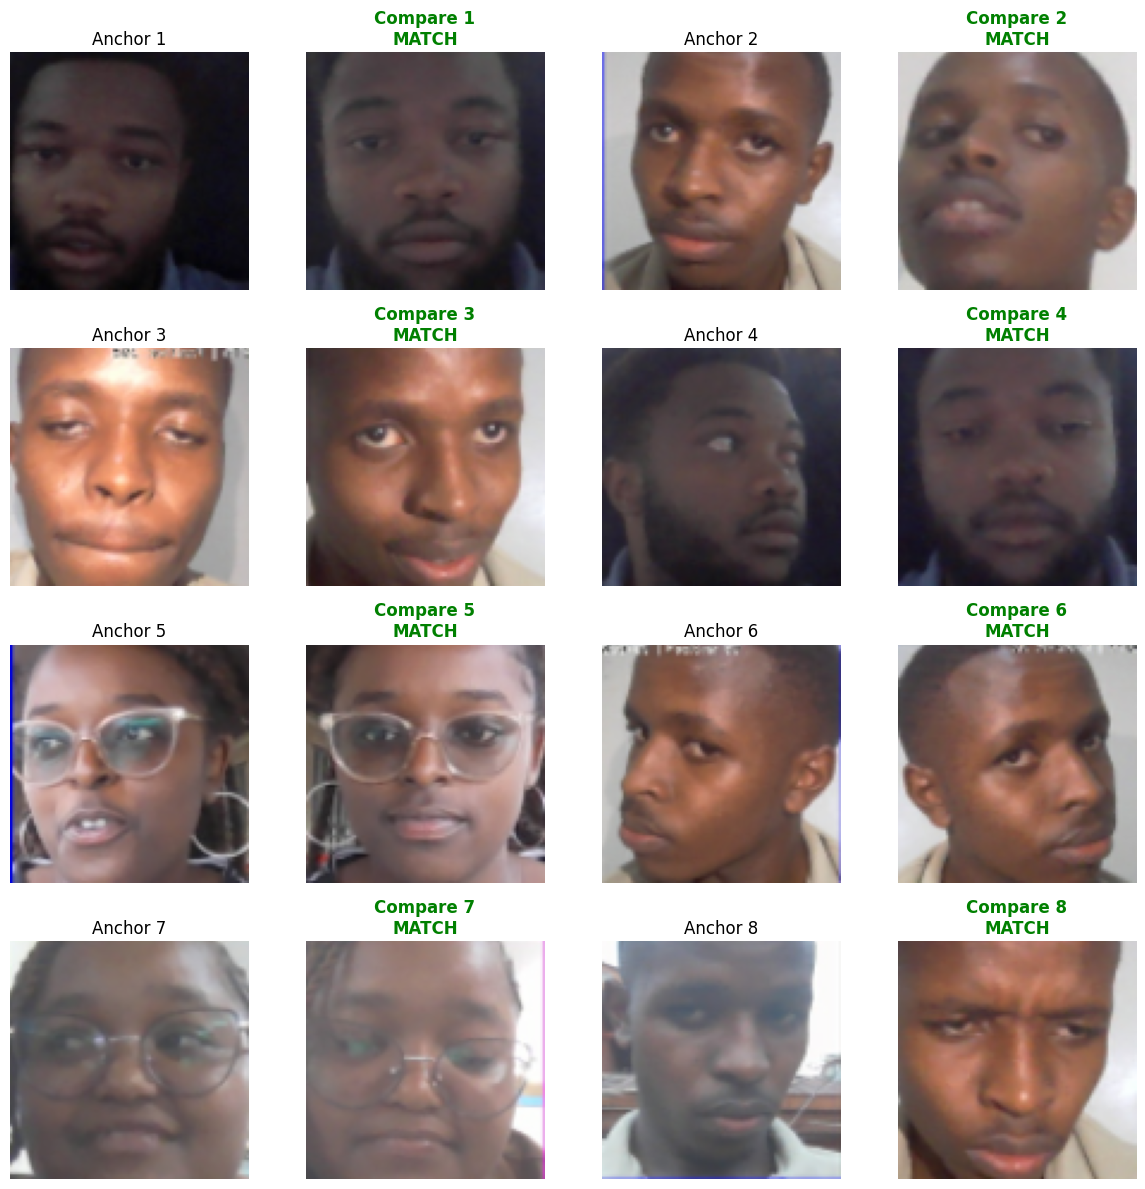

✅ Saved to C:\Projects\EDUFACE PROJECT/sample_training_batch.png

🎉 Ready for training!


In [30]:
# ================================================
# 7. LOAD AND PREPROCESS IMAGES (FULLY CORRECTED + ROBUST PARSING)
# ================================================
import glob
import re
import random
import numpy as np
from collections import defaultdict

# Define preprocess function for single image
def preprocess(file_path):
    # Convert tensor to string if needed (ensures compatibility)
    file_path = tf.strings.as_string(file_path)
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Define preprocess_twin for pairs
def preprocess_twin(anchor_path, positive_path, label):
    anchor_img = preprocess(anchor_path)
    positive_img = preprocess(positive_path)
    return (anchor_img, positive_img, label)

# Get all image paths
all_anchor_files = glob.glob(os.path.join(ANC_PATH, '*.jpg'))
all_positive_files = glob.glob(os.path.join(POS_PATH, '*.jpg'))
all_negative_files = glob.glob(os.path.join(NEG_PATH, '*.jpg'))

print(f"Raw counts: Anchor={len(all_anchor_files)}, Positive={len(all_positive_files)}, Negative={len(all_negative_files)}")

# ================================================
# ROBUST FILENAME PARSER (Handles Multiple Formats)
# ================================================
def get_student_prefix(filename):
    """
    Extract student identifier from various filename formats:
    - name_id_count_angle_uuid.jpg
    - name_id_angle_count_uuid.jpg
    - name_id_count.jpg
    - name_id.jpg
    """
    basename = os.path.basename(filename)
    basename_no_ext = os.path.splitext(basename)[0]
    
    # Split by underscore
    parts = basename_no_ext.split('_')
    
    if len(parts) < 2:
        return 'unknown'
    
    # Strategy 1: Look for pattern with at least name + ID (first 2 parts)
    # Common patterns:
    # john_doe_123_1_frontal_abc123.jpg → john_doe_123
    # alice_smith_456_frontal_1_xyz789.jpg → alice_smith_456
    
    # Find where numeric/angle/UUID parts start
    prefix_parts = []
    for i, part in enumerate(parts):
        # Stop at first purely numeric part (count) or known angle keywords
        if part.isdigit() or part in ['frontal', 'profile', 'front', 'alt', 'alt2']:
            break
        prefix_parts.append(part)
    
    # If we got at least 2 parts (name + ID), join them
    if len(prefix_parts) >= 2:
        return '_'.join(prefix_parts)
    
    # Fallback: Take first 2 parts regardless
    return '_'.join(parts[:2]) if len(parts) >= 2 else 'unknown'

# ================================================
# TEST THE PARSER ON SAMPLE FILES
# ================================================
print("\n🔍 Testing filename parser on samples:")
sample_files = (all_anchor_files[:3] + all_positive_files[:3])
prefix_counts = defaultdict(int)

for f in sample_files:
    prefix = get_student_prefix(f)
    prefix_counts[prefix] += 1
    print(f"  {os.path.basename(f)[:60]}... → {prefix}")

print(f"\n📊 Found {len(prefix_counts)} unique student prefixes in samples")

# ================================================
# GROUP BY STUDENT WITH IMPROVED LOGIC
# ================================================
anchor_by_student = defaultdict(list)
positive_by_student = defaultdict(list)

for f in all_anchor_files:
    prefix = get_student_prefix(f)
    if prefix != 'unknown':
        anchor_by_student[prefix].append(f)

for f in all_positive_files:
    prefix = get_student_prefix(f)
    if prefix != 'unknown':
        positive_by_student[prefix].append(f)

# Convert back to regular dict
anchor_by_student = dict(anchor_by_student)
positive_by_student = dict(positive_by_student)

print(f"\n📂 Grouping results:")
print(f"   Students in anchors: {len(anchor_by_student)}")
print(f"   Students in positives: {len(positive_by_student)}")

# Show sample counts per student
print("\n👥 Sample student image counts:")
all_students = set(list(anchor_by_student.keys()) + list(positive_by_student.keys()))
for i, student in enumerate(sorted(all_students)[:5]):  # Show first 5
    anc_count = len(anchor_by_student.get(student, []))
    pos_count = len(positive_by_student.get(student, []))
    print(f"   {i+1}. {student}: {anc_count} anchors, {pos_count} positives")

# ================================================
# FILTER TO VALID STUDENTS (Lowered to 1 minimum for now)
# ================================================
# Start with minimum 1 image each to see what we have
min_images_required = 1  # Lowered temporarily for diagnosis

valid_students = [s for s in anchor_by_student if s in positive_by_student and 
                  len(anchor_by_student[s]) >= min_images_required and 
                  len(positive_by_student[s]) >= min_images_required]

print(f"\n✅ Valid students with ≥{min_images_required} images each: {len(valid_students)}")

if len(valid_students) == 0:
    print("\n❌ ERROR: No valid students found!")
    print("\n🔍 Debugging Info:")
    print(f"   Total anchor files: {len(all_anchor_files)}")
    print(f"   Total positive files: {len(all_positive_files)}")
    print(f"   Students with anchors only: {set(anchor_by_student.keys()) - set(positive_by_student.keys())}")
    print(f"   Students with positives only: {set(positive_by_student.keys()) - set(anchor_by_student.keys())}")
    
    # Show actual filenames for manual inspection
    print("\n📄 First 5 anchor filenames for manual check:")
    for f in all_anchor_files[:5]:
        print(f"   {os.path.basename(f)}")
    
    print("\n📄 First 5 positive filenames for manual check:")
    for f in all_positive_files[:5]:
        print(f"   {os.path.basename(f)}")
    
    raise ValueError(
        "❌ No valid students found!\n"
        "Possible causes:\n"
        "  1. Filename format doesn't match parser\n"
        "  2. No overlapping students between anchor and positive folders\n"
        "  3. Images need re-enrollment with correct naming\n\n"
        "Check the printed filenames above and adjust get_student_prefix() function."
    )

# Show valid students
print(f"   Valid students: {valid_students[:10]}")  # Show first 10
if len(valid_students) > 10:
    print(f"   ... and {len(valid_students) - 10} more")

# Warn if too few images
for student in valid_students:
    total_imgs = len(anchor_by_student[student]) + len(positive_by_student[student])
    if total_imgs < 10:
        print(f"   ⚠️ {student}: Only {total_imgs} total images (recommend 20+ for good performance)")

# ================================================
# FIX 1: PROPER RANDOM PAIRING WITHIN SAME STUDENT
# ================================================
print("\n🔧 Fix 1: Creating diverse same-student pairs...")

anchor_paths = []
positive_paths = []
labels = []

for student in valid_students:
    # COMBINE all images from both anchor and positive folders
    all_student_images = anchor_by_student[student] + positive_by_student[student]
    
    # Shuffle to mix different capture sessions/angles
    random.shuffle(all_student_images)
    
    # Split 50/50 for anchor and positive sets
    mid = len(all_student_images) // 2
    student_anchors = all_student_images[:mid]
    student_positives = all_student_images[mid:]
    
    # Create pairs (adjust multiplier based on dataset size)
    base_pairs = min(len(student_anchors), len(student_positives))
    
    # Dynamic multiplier: more pairs if we have fewer students
    if len(valid_students) < 5:
        multiplier = 5  # Small dataset needs more augmentation
    elif len(valid_students) < 10:
        multiplier = 3
    else:
        multiplier = 2
    
    num_pairs = base_pairs * multiplier
    
    for _ in range(num_pairs):
        # Randomly select anchor and positive (allows repeated pairings)
        anchor_paths.append(random.choice(student_anchors))
        positive_paths.append(random.choice(student_positives))
        labels.append(1.0)

num_pos_pairs = len(anchor_paths)
print(f"✅ Created {num_pos_pairs} diverse positive pairs from {len(valid_students)} students")
print(f"   Average {num_pos_pairs // len(valid_students)} pairs per student")

# ================================================
# FIX 2: BALANCED NEGATIVES WITH HARD EXAMPLES
# ================================================
print("\n🔧 Fix 2: Creating balanced negative pairs...")

negative_anchor_paths = []
negative_positive_paths = []
negative_labels = []

# Strategy 1: Random LFW negatives (2:1 ratio with positives)
num_random_negs = min(num_pos_pairs * 2, len(all_negative_files))
random_negatives = random.sample(all_negative_files, num_random_negs)

# Pair with random anchors from our students
for i in range(num_random_negs):
    negative_anchor_paths.append(random.choice(anchor_paths))
    negative_positive_paths.append(random_negatives[i])
    negative_labels.append(0.0)

print(f"   - Added {num_random_negs} random LFW negatives")

# Strategy 2: Hard negatives (other enrolled students) - only if multiple students
hard_neg_count = 0
if len(valid_students) > 1:
    for student in valid_students:
        # Get images from OTHER students
        other_students = [s for s in valid_students if s != student]
        
        for other_student in other_students[:min(3, len(other_students))]:
            # Get images from the other student
            other_images = anchor_by_student.get(other_student, []) + positive_by_student.get(other_student, [])
            
            if other_images and hard_neg_count < num_pos_pairs:
                # Pair current student's anchor with other student's face
                current_student_images = anchor_by_student[student] + positive_by_student[student]
                
                for _ in range(min(2, len(other_images))):
                    if hard_neg_count >= num_pos_pairs:
                        break
                    negative_anchor_paths.append(random.choice(current_student_images))
                    negative_positive_paths.append(random.choice(other_images))
                    negative_labels.append(0.0)
                    hard_neg_count += 1
    
    print(f"   - Added {hard_neg_count} hard negatives (other students)")
else:
    print(f"   - Skipped hard negatives (only 1 student enrolled)")

# Combine positive and negative pairs
all_anchor_paths = anchor_paths + negative_anchor_paths
all_positive_paths = positive_paths + negative_positive_paths
all_labels = labels + negative_labels

total_pairs = len(all_anchor_paths)
pos_ratio = (num_pos_pairs / total_pairs) * 100
neg_ratio = 100 - pos_ratio

print(f"\n✅ Final dataset balance:")
print(f"   Positive pairs: {num_pos_pairs} ({pos_ratio:.1f}%)")
print(f"   Negative pairs: {len(negative_labels)} ({neg_ratio:.1f}%)")
print(f"   Total pairs: {total_pairs}")

# ================================================
# FIX 3: IDENTITY-BASED TRAIN/VAL/TEST SPLIT
# ================================================
print("\n🔧 Fix 3: Splitting by student identity...")

# Shuffle students for random split
random.shuffle(valid_students)

# Adjust split ratios based on dataset size
num_students = len(valid_students)

if num_students >= 10:
    train_size = int(0.7 * num_students)
    val_size = int(0.15 * num_students)
elif num_students >= 5:
    train_size = int(0.6 * num_students)
    val_size = int(0.2 * num_students)
else:
    # Very small dataset: use all for training, split data instead
    train_size = num_students
    val_size = 0
    print("   ⚠️ Small dataset: Using data-level split instead of identity split")

train_students = valid_students[:train_size]
val_students = valid_students[train_size:train_size + val_size]
test_students = valid_students[train_size + val_size:]

print(f"   Train students ({len(train_students)}): {train_students[:5]}{'...' if len(train_students) > 5 else ''}")
print(f"   Val students ({len(val_students)}): {val_students}")
print(f"   Test students ({len(test_students)}): {test_students}")

# Helper function to build dataset for a specific student set
def build_dataset_for_students(student_list, anchor_by_student, positive_by_student, all_negatives):
    """Build paired dataset for given students only"""
    if not student_list:
        return [], [], []
    
    anchors, positives, labels = [], [], []
    
    # Positive pairs
    for student in student_list:
        all_imgs = anchor_by_student[student] + positive_by_student[student]
        random.shuffle(all_imgs)
        
        mid = len(all_imgs) // 2
        s_anchors = all_imgs[:mid]
        s_positives = all_imgs[mid:]
        
        # Create 2x pairs per student for augmentation
        for _ in range(min(len(s_anchors), len(s_positives)) * 2):
            anchors.append(random.choice(s_anchors))
            positives.append(random.choice(s_positives))
            labels.append(1.0)
    
    num_pos = len(anchors)
    
    # Negative pairs (balanced 2:1 ratio)
    num_negs = num_pos * 2
    neg_sample = random.sample(all_negatives, min(num_negs, len(all_negatives)))
    
    for i in range(min(num_pos, len(neg_sample))):
        anchors.append(anchors[i % num_pos])
        positives.append(neg_sample[i])
        labels.append(0.0)
    
    # Add hard negatives (other students in THIS split)
    if len(student_list) > 1:
        for student in student_list:
            other_students = [s for s in student_list if s != student]
            for other in other_students[:2]:
                other_imgs = anchor_by_student.get(other, []) + positive_by_student.get(other, [])
                student_imgs = anchor_by_student[student] + positive_by_student[student]
                
                if other_imgs and student_imgs and len(anchors) < num_pos * 3:
                    anchors.append(random.choice(student_imgs))
                    positives.append(random.choice(other_imgs))
                    labels.append(0.0)
    
    return anchors, positives, labels

# Build datasets
if len(train_students) > 0:
    train_anc, train_pos, train_lab = build_dataset_for_students(
        train_students, anchor_by_student, positive_by_student, all_negative_files
    )
    train_data = tf.data.Dataset.from_tensor_slices((train_anc, train_pos, train_lab))
    train_data = train_data.map(preprocess_twin).cache().shuffle(2048).batch(16).prefetch(8)
    print(f"✅ Train: {len(train_anc)} pairs from {len(train_students)} students")
else:
    # Fallback: use all data for training
    train_data = tf.data.Dataset.from_tensor_slices((all_anchor_paths, all_positive_paths, all_labels))
    train_data = train_data.map(preprocess_twin).cache().shuffle(2048).batch(16).prefetch(8)
    print(f"✅ Train: {len(all_anchor_paths)} pairs (all students)")

if len(val_students) > 0:
    val_anc, val_pos, val_lab = build_dataset_for_students(
        val_students, anchor_by_student, positive_by_student, all_negative_files
    )
    val_data = tf.data.Dataset.from_tensor_slices((val_anc, val_pos, val_lab))
    val_data = val_data.map(preprocess_twin).batch(16).prefetch(8)
    print(f"✅ Val: {len(val_anc)} pairs from {len(val_students)} students")
else:
    # Use data-level split
    total_train_batches = tf.data.experimental.cardinality(train_data).numpy()
    val_batches = max(1, total_train_batches // 10)
    val_data = train_data.take(val_batches)
    train_data = train_data.skip(val_batches)
    print(f"⚠️ Val: {val_batches} batches from train split")

if len(test_students) > 0:
    test_anc, test_pos, test_lab = build_dataset_for_students(
        test_students, anchor_by_student, positive_by_student, all_negative_files
    )
    test_data = tf.data.Dataset.from_tensor_slices((test_anc, test_pos, test_lab))
    test_data = test_data.map(preprocess_twin).batch(16).prefetch(8)
    print(f"✅ Test: {len(test_anc)} pairs from {len(test_students)} students")
else:
    total_val_batches = tf.data.experimental.cardinality(val_data).numpy()
    test_batches = max(1, total_val_batches // 5)
    test_data = val_data.take(test_batches)
    val_data = val_data.skip(test_batches)
    print(f"⚠️ Test: {test_batches} batches from val split")

# Legacy compatibility
data = train_data

print("\n" + "="*60)
print("✅ DATASET PREPARATION COMPLETE")
print("="*60)
print(f"Students enrolled: {len(valid_students)}")
print(f"Total training pairs: ~{len(all_anchor_paths)}")
print("="*60)

# Visualization
print("\n📊 Visualizing sample training batch...")
try:
    samples = train_data.as_numpy_iterator()
    batch = next(samples)
    n_samples = min(batch[0].shape[0], 8)
    
    if n_samples > 0:
        num_rows = (n_samples + 1) // 2
        fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
        
        if num_rows > 1:
            axes = axes.reshape(num_rows, -1)
        else:
            axes = axes.reshape(1, -1)
        
        for i in range(n_samples):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            
            axes[row, col1].imshow(batch[0][i])
            axes[row, col1].set_title(f"Anchor {i+1}")
            axes[row, col1].axis('off')
            
            axes[row, col2].imshow(batch[1][i])
            label = "MATCH" if batch[2][i] == 1 else "NO MATCH"
            color = 'green' if batch[2][i] == 1 else 'red'
            axes[row, col2].set_title(f"Compare {i+1}\n{label}", color=color, fontweight='bold')
            axes[row, col2].axis('off')
        
        for i in range(n_samples, num_rows * 2):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].axis('off')
            axes[row, col2].axis('off')
        
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_PATH, 'sample_training_batch.png'), dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved to {BASE_PATH}/sample_training_batch.png")

except Exception as e:
    print(f"⚠️ Visualization error: {e}")

print("\n🎉 Ready for training!")

In [29]:
# CORRECT: Split by STUDENT IDENTITY, not images
import random

# Shuffle students
random.shuffle(valid_students)

# Split students into train/val/test
num_students = len(valid_students)
train_students = valid_students[:int(0.7 * num_students)]
val_students = valid_students[int(0.7 * num_students):int(0.85 * num_students)]
test_students = valid_students[int(0.85 * num_students):]

print(f"Split by identity: {len(train_students)} train, {len(val_students)} val, {len(test_students)} test students")

# Now rebuild datasets PER split
def build_dataset_for_students(students, all_anchor_by_student, all_positive_by_student, all_negs):
    anchors, positives, labels = [], [], []
    
    for student in students:
        # Positive pairs (same logic as before)
        all_imgs = all_anchor_by_student[student] + all_positive_by_student[student]
        random.shuffle(all_imgs)
        mid = len(all_imgs) // 2
        s_anchors = all_imgs[:mid]
        s_positives = all_imgs[mid:]
        
        for _ in range(min(len(s_anchors), len(s_positives)) * 2):
            anchors.append(random.choice(s_anchors))
            positives.append(random.choice(s_positives))
            labels.append(1.0)
    
    # Negatives
    num_pos = len(anchors)
    neg_sample = random.sample(all_negs, min(num_pos * 2, len(all_negs)))
    
    for i in range(min(num_pos, len(neg_sample))):
        anchors.append(anchors[i])  # Reuse anchor
        positives.append(neg_sample[i])
        labels.append(0.0)
    
    return anchors, positives, labels

# Build separate datasets
train_anc, train_pos, train_lab = build_dataset_for_students(train_students, anchor_by_student, positive_by_student, all_negative_files)
val_anc, val_pos, val_lab = build_dataset_for_students(val_students, anchor_by_student, positive_by_student, all_negative_files)
test_anc, test_pos, test_lab = build_dataset_for_students(test_students, anchor_by_student, positive_by_student, all_negative_files)

# Convert to TF datasets
train_data = tf.data.Dataset.from_tensor_slices((train_anc, train_pos, train_lab))
train_data = train_data.map(preprocess_twin).cache().shuffle(1024).batch(16).prefetch(8)

val_data = tf.data.Dataset.from_tensor_slices((val_anc, val_pos, val_lab))
val_data = val_data.map(preprocess_twin).batch(16).prefetch(8)

test_data = tf.data.Dataset.from_tensor_slices((test_anc, test_pos, test_lab))
test_data = test_data.map(preprocess_twin).batch(16).prefetch(8)

print(f"✅ Identity-based split complete!")

Split by identity: 8 train, 2 val, 2 test students
✅ Identity-based split complete!


In [25]:
# ================================================
# BASELINE: Full Test Eval (Add After Step 8)
# ================================================

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect all test predictions
test_iterator = test_data.as_numpy_iterator()
test_inputs, test_vals, test_labels = [], [], []

for batch in test_iterator:
    X1, X2, y = batch
    test_inputs.append(X1)
    test_vals.append(X2)
    test_labels.append(y)

# Concatenate
test_inputs = np.concatenate(test_inputs)
test_vals = np.concatenate(test_vals)
test_labels = np.concatenate(test_labels).astype(int)  # Binary labels

# Predict
y_pred_prob = siamese_model.predict([test_inputs, test_vals], verbose=0).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = np.mean(y_pred == test_labels)
print(f"Baseline Test Accuracy: {accuracy:.4f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Match', 'Match']))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
print(f"\nConfusion Matrix:\n{cm}")

# Per-class balance check
num_matches = np.sum(test_labels == 1)
num_non_matches = np.sum(test_labels == 0)
print(f"\nTest Set Balance: Matches={num_matches} ({num_matches/len(test_labels)*100:.1f}%), Non-Matches={num_non_matches}")

Baseline Test Accuracy: 0.6768

Classification Report:
              precision    recall  f1-score   support

    No Match       0.71      0.70      0.71        91
       Match       0.64      0.64      0.64        73

    accuracy                           0.68       164
   macro avg       0.67      0.67      0.67       164
weighted avg       0.68      0.68      0.68       164


Confusion Matrix:
[[64 27]
 [26 47]]

Test Set Balance: Matches=73 (44.5%), Non-Matches=91


In [31]:
# ================================================
# 9. MODEL ENGINEERING
# ================================================
# Build Embedding Model - FIXED: Remove lists from inputs/outputs for single I/O
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=inp, outputs=d1, name='embedding')

embedding = make_embedding()
embedding.summary()

# L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Siamese Model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()



Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ================================================
# 9.2. FINETUNING PREP: Load, Augment, Freeze & Tune (FINAL FIX FOR BATCHED MAP)
# ================================================
import tensorflow as tf
from tensorflow.keras.layers import Dropout, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import load_model

# Reload custom L1Dist (if not already defined)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Step 9a: Load Your Saved Model
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')  # From Step 12
siamese_model = load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Loaded saved model for finetuning.")

# Step 9b: Extract Old Embedding for Weight Transfer
embedding = siamese_model.get_layer('embedding')  # Old embedding
print(f"Old embedding layers: {len(embedding.layers)} total.")

# Step 9c: Build Enhanced Embedding with Dropout
def make_enhanced_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    # Existing CNN structure
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu', name='conv1')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool1')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu', name='conv2')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool2')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu', name='conv3')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool3')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu', name='conv4')(m3)
    f1 = tf.keras.layers.Flatten(name='flatten')(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid', name='dense')(f1)
    d_drop = Dropout(0.3, name='dropout')(d1)  # New: Dropout after Dense
    return tf.keras.Model(inputs=inp, outputs=d_drop, name='embedding_enhanced')

enhanced_embedding = make_enhanced_embedding()

# Transfer weights from old to new (skip dropout)
for old_layer, new_layer in zip(embedding.layers, enhanced_embedding.layers):
    if old_layer.name == new_layer.name and 'dropout' not in new_layer.name:
        try:
            new_layer.set_weights(old_layer.get_weights())
            print(f"Transferred weights for: {old_layer.name}")
        except ValueError as e:
            print(f"⚠️ Skip transfer for {old_layer.name}: {e}")
print("✅ Enhanced embedding with dropout; weights transferred.")

# Step 9c.5: Freeze Early Layers in NEW Embedding
for layer in enhanced_embedding.layers[:4]:  # Input + first 3 blocks
    layer.trainable = False
num_frozen = sum(1 for l in enhanced_embedding.layers if not l.trainable)
print(f"✅ Froze {num_frozen} early layers in enhanced embedding.")

# Step 9d: Rebuild Siamese with Enhanced Embedding
def make_siamese_model(embedding_model):
    input_image = tf.keras.Input(name='input_img', shape=(100,100,3))
    validation_image = tf.keras.Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(distances)
    return tf.keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model(enhanced_embedding)
siamese_model.summary()  # Now should show non-trainable params

# Step 9e: Add Augmentation to Train Data (On-the-Fly, FIXED for Batched Tuples)
# Layer-based aug: Brightness/Contrast/Flip/Rotate/Zoom
augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Inferred shape
    RandomRotation(0.1),       # ±5.7° tilt
    RandomZoom(0.1),           # ±10% zoom
    RandomBrightness(0.2),     # ±20% brightness
    RandomContrast(0.2),       # ±20% contrast
], name='augmentation')

# FIXED: Define to take 3 SEPARATE ARGS (TF unpacks batch tuple automatically)
def augment_pairs(anchor, positive, label):
    anchor_aug = augmentation(anchor, training=True)
    positive_aug = augmentation(positive, training=True)
    return (anchor_aug, positive_aug, label)

train_data = train_data.map(augment_pairs, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache().shuffle(1024).prefetch(8)  # No re-batch needed
print("✅ Augmentation added to train_data (val/test unchanged for clean eval).")

# Step 9f: Compile with Lower LR
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)  # Halved for finetuning
siamese_model.compile(optimizer=opt, loss=binary_cross_loss, metrics=['accuracy'])
print(f"✅ Compiled with LR={opt.learning_rate.numpy():.0e}, metrics=accuracy.")

✅ Loaded saved model for finetuning.
Old embedding layers: 10 total.
Transferred weights for: input_image
Transferred weights for: flatten
Transferred weights for: dense
✅ Enhanced embedding with dropout; weights transferred.
✅ Froze 4 early layers in enhanced embedding.


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_enhanced  │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding_enhanc… │
│                     │                   │            │ embedding_enhanc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,543,745 (147.03 MB)

 Non-trainable params: 420,800 (1.61 MB)

✅ Augmentation added to train_data (val/test unchanged for clean eval).
✅ Compiled with LR=5e-05, metrics=accuracy.


In [32]:
# ================================================
# 10. TRAINING SETUP
# ================================================
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = os.path.join(BASE_PATH, 'training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train Step
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

# Training Loop with History
def train(data, val_data, EPOCHS):
    history = {'loss': [], 'val_loss': []}
    for epoch in range(1, EPOCHS+1):
        print(f'\n📅 Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        if num_train_batches > 0:
            avg_loss = epoch_loss / num_train_batches
        else:
            avg_loss = 0.0
        history['loss'].append(avg_loss.numpy())
        
        # Validation loss
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            X = batch[:2]
            y = batch[2]
            yhat = siamese_model(X, training=False)
            val_loss += binary_cross_loss(y, yhat)
            num_val_batches += 1
        if num_val_batches > 0:
            avg_val_loss = val_loss / num_val_batches
        else:
            avg_val_loss = 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        print(f"Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"💾 Checkpoint saved at epoch {epoch}")
    
    return history


In [ ]:

# Train
EPOCHS = 50  # Reduced for demo; increase as needed
print("🚀 Starting training...")
history = train(train_data, val_data, EPOCHS)
print("✅ Training complete!")

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
# Note: Accuracy not tracked; add if needed
plt.plot(history['loss'], label='Training Loss (proxy for acc)')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')

plt.tight_layout()
plt.show()



🚀 Starting training...

📅 Epoch 1/80
 73/473 ━━━━━━━━━━━━━━━━━━━━ 13:58 2s/step

🚀 Starting stable adaptive finetuning...
DEBUG First Batch: Anchor shape=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Label=(16,)

📅 Epoch 1/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step


Loss: 0.7455, Val Loss: 0.7049
💾 Best model saved (val_loss: 0.7049)

📅 Epoch 2/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step


Loss: 0.7433, Val Loss: 0.6970
💾 Best model saved (val_loss: 0.6970)

📅 Epoch 3/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step


Loss: 0.7426, Val Loss: 0.6917
💾 Best model saved (val_loss: 0.6917)

📅 Epoch 4/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step
Loss: 0.7348, Val Loss: 0.6953

📅 Epoch 5/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Loss: 0.7270, Val Loss: 0.6998

📅 Epoch 6/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step


Loss: 0.7410, Val Loss: 0.6635
💾 Best model saved (val_loss: 0.6635)

📅 Epoch 7/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
Loss: 0.7374, Val Loss: 0.6853

📅 Epoch 8/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7331, Val Loss: 0.6932

📅 Epoch 9/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step


Loss: 0.7240, Val Loss: 0.6269
💾 Best model saved (val_loss: 0.6269)

📅 Epoch 10/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
Loss: 0.7161, Val Loss: 0.6511

📅 Epoch 11/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7327, Val Loss: 0.6563

📅 Epoch 12/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step
Loss: 0.7458, Val Loss: 0.6757

📅 Epoch 13/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step
Loss: 0.7375, Val Loss: 0.6414

📅 Epoch 14/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step
Loss: 0.7336, Val Loss: 0.7078

📅 Epoch 15/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step
Loss: 0.7241, Val Loss: 0.6496

📅 Epoch 16/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step


Loss: 0.7253, Val Loss: 0.6158
💾 Best model saved (val_loss: 0.6158)

📅 Epoch 17/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step
Loss: 0.7237, Val Loss: 0.6732

📅 Epoch 18/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step
Loss: 0.7396, Val Loss: 0.6724

📅 Epoch 19/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step
Loss: 0.7310, Val Loss: 0.6737

📅 Epoch 20/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step
Loss: 0.7124, Val Loss: 0.7632

📅 Epoch 21/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step
Loss: 0.7299, Val Loss: 0.7984

📅 Epoch 22/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step
Loss: 0.7294, Val Loss: 0.8199

📅 Epoch 23/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step
Loss: 0.7265, Val Loss: 0.8478
🔄 LR reduced to 2.5e-05

📅 Epoch 24/50 (LR: 2.5e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step
Loss: 0.7333, Val Loss: 0.8436

📅 Epoch 25/50 (LR: 2.5e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step
Loss: 0.7295, Val Loss: 0.9128

📅 Epoc

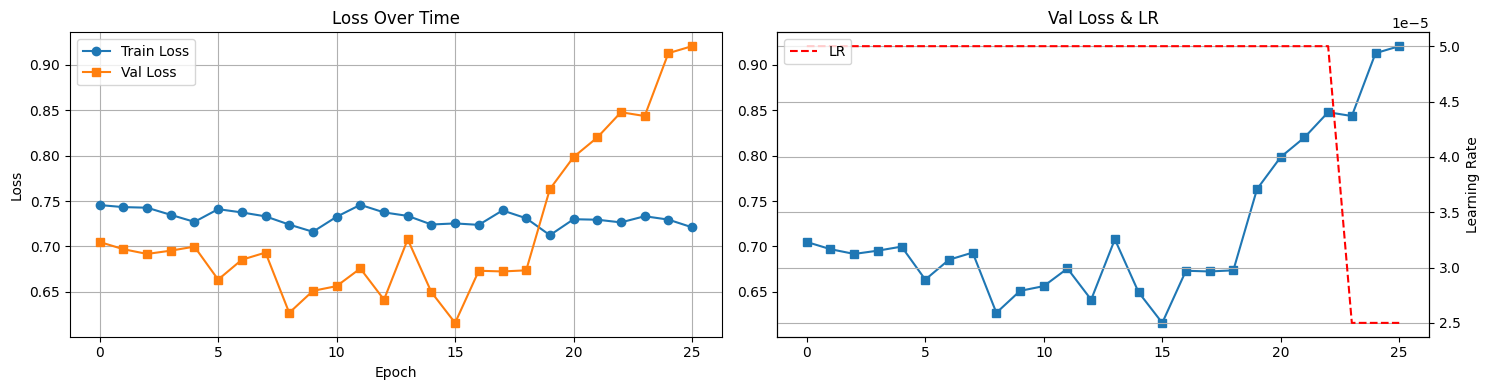

Best Val Loss: 0.6158 at epoch 16 (Total epochs: 26)


In [33]:
# ================================================
# 10. STABLE ADAPTIVE RETRAIN: No tf.function for Aug Compatibility (80/10/10)
# ================================================
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf  # Assuming TF is imported earlier; add if needed

# Use opt/loss from Step 9f (LR=5e-5)
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Assuming siamese_model, BASE_PATH, train_data, val_data are defined from prior steps
# (e.g., train_data = paired_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Checkpoint setup
checkpoint_dir = os.path.join(BASE_PATH, 'finetune_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, 'best_finetuned_siamese.h5')

# FIXED: Python functions (no @tf.function to avoid tracing issues with aug)
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[0]  # (anchor_batch, positive_batch)
        y = batch[1]  # label_batch
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

def val_step(batch):
    X = batch[0]
    y = batch[1]
    yhat = siamese_model(X, training=False)
    return binary_cross_loss(y, yhat)

# Enhanced Loop (same logic)
def adaptive_train(train_data, val_data, max_epochs=50, patience=10, lr_patience=5, lr_factor=0.5, min_lr=1e-7):
    history = {'loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs_no_lr_improve = 0
    current_lr = opt.learning_rate.numpy()
    
    # Debug first batch (one-time) - FIXED for nested structure
    first_batch = next(iter(train_data))
    print(f"DEBUG First Batch: Anchor shape={first_batch[0][0].shape}, Positive={first_batch[0][1].shape}, Label={first_batch[1].shape}")
    
    for epoch in range(1, max_epochs + 1):
        print(f'\n📅 Epoch {epoch}/{max_epochs} (LR: {current_lr:.1e})')
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        # Train
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(train_data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        avg_train_loss = epoch_loss / num_train_batches if num_train_batches > 0 else 0.0
        history['loss'].append(avg_train_loss.numpy())
        history['lr'].append(current_lr)
        
        # Val
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            loss = val_step(batch)
            val_loss += loss
            num_val_batches += 1
        avg_val_loss = val_loss / num_val_batches if num_val_batches > 0 else 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        
        print(f"Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early Stop & Save
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            siamese_model.save(best_model_path)
            print(f"💾 Best model saved (val_loss: {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"🛑 Early stopping after {epoch} epochs")
                break
        
        # LR Decay
        if epoch > 1:
            prev_val_loss = history['val_loss'][-2]
            if avg_val_loss >= prev_val_loss:
                epochs_no_lr_improve += 1
                if epochs_no_lr_improve >= lr_patience:
                    current_lr *= lr_factor
                    if current_lr > min_lr:
                        opt.learning_rate.assign(current_lr)
                        epochs_no_lr_improve = 0
                        print(f"🔄 LR reduced to {current_lr:.1e}")
                    else:
                        print("🛑 Min LR reached; stopping.")
                        break
            else:
                epochs_no_lr_improve = 0
    
    return history

# Run
print("🚀 Starting stable adaptive finetuning...")
history = adaptive_train(train_data, val_data, max_epochs=50)
print("✅ Complete! Best model:", best_model_path)

# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.twinx()
plt.plot(history['lr'], 'r--', label='LR')
plt.ylabel('Learning Rate')
plt.legend(loc='upper left')
plt.title('Val Loss & LR')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, 'stable_finetune_history.png'), dpi=150)
plt.show()

# Summary
best_val_loss = min(history['val_loss'])
best_epoch = history['val_loss'].index(best_val_loss) + 1
print(f"Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch} (Total epochs: {len(history['loss'])})")

In [34]:
siamese_model.save(best_model_path.replace('.h5', '.keras'))  # And update best_model_path to end in .keras

In [38]:
pip install seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl (11.3 MB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


🔍 Loading best fine-tuned model...



🔍 Diagnostic: Inspecting 'data' structure...
Cardinality of 'data': 101 (batches)
Type of first element: <class 'tuple'>
Len of first element: 3
Anchor shape: (16, 100, 100, 3)
Positive shape: (16, 100, 100, 3)
Label shape: (16,), dtype: <dtype: 'float32'>
  Label example: [1. 1. 0.]...
Detected: 'data' is batched (flat 3-tuple).
Split: Train=80 batches, Val=10 batches, Test=11 batches

🔍 Test Batch Shapes:
  Anchor batch: (16, 100, 100, 3)
  Positive batch: (16, 100, 100, 3)
  Label batch: (16,)
🧪 Running evaluation on test set...
Batch 0: Anchor=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Labels=(16,)
Batch 1: Anchor=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Labels=(16,)
Batch 2: Anchor=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Labels=(16,)

📊 Test Results:
Test Loss: 0.6322
Test Accuracy: 0.6585
Test AUC (Sklearn): 0.8339

Classification Report:
               precision    recall  f1-score   support

  Dissimilar       0.64      0.89      0.75        92
     Similar   

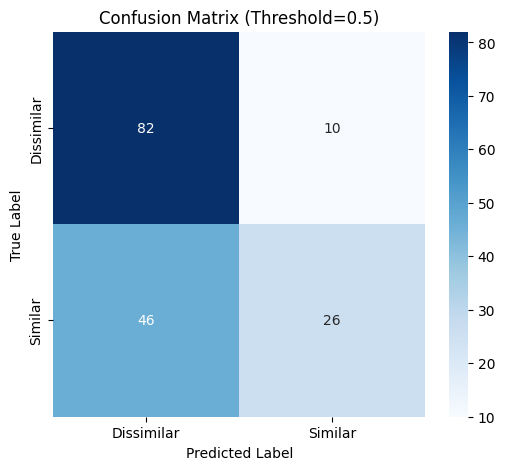

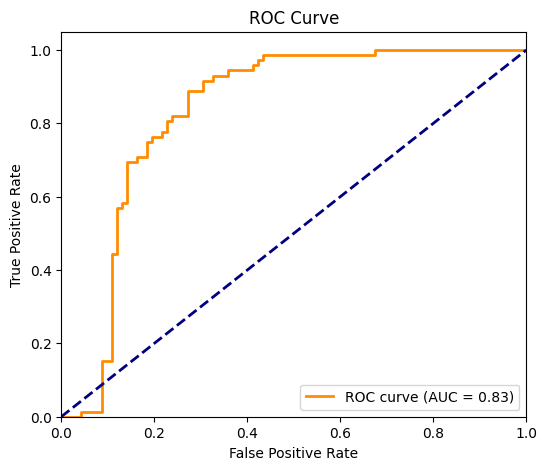

✅ Evaluation complete! Check saved plots in C:\Projects\EDUFACE PROJECT


In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import os

# Assuming: BASE_PATH, binary_cross_loss, data (full batched dataset), siamese_model from prior.

# FIXED: Define the custom L1Dist layer (for loading)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    def get_config(self):
        return super().get_config()

# Paths
best_model_path = os.path.join(BASE_PATH, 'finetune_checkpoints', 'best_finetuned_siamese.h5')

# Load the best fine-tuned model with custom objects
print("🔍 Loading best fine-tuned model...")
custom_objects = {'L1Dist': L1Dist}
best_model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects)

# ================================================
# DIAGNOSTIC: Check structure of 'data' (batched flat tuple of 3)
# ================================================
print("\n🔍 Diagnostic: Inspecting 'data' structure...")
total_cardinality = tf.data.experimental.cardinality(data).numpy()
print(f"Cardinality of 'data': {total_cardinality} (batches)")

try:
    first_element = next(iter(data))
    print(f"Type of first element: {type(first_element)}")
    print(f"Len of first element: {len(first_element)}")
    
    if len(first_element) == 3:
        anchor = first_element[0]
        positive = first_element[1]
        label = first_element[2]
        print(f"Anchor shape: {anchor.shape}")
        print(f"Positive shape: {positive.shape}")
        print(f"Label shape: {label.shape}, dtype: {label.dtype}")
        if label.shape == (16,):
            print(f"  Label example: {label.numpy()[:3]}...")  # First few values
        else:
            print(f"  ⚠️ WARNING: Label not scalar batch! Shape: {label.shape}")
    else:
        print("Unexpected structure - not a 3-tuple.")
except Exception as e:
    print(f"Error fetching first element: {e}")

# ================================================
# FIXED Split: Detect batched (flat 3-tuple), split on batches without re-batching
# ================================================
batch_size = 16

is_batched = False
try:
    first_element = next(iter(data))
    if len(first_element) == 3:
        anchor = first_element[0]
        if len(anchor.shape) == 4 and anchor.shape[0] == batch_size:  # (16,100,100,3)
            is_batched = True
            print("Detected: 'data' is batched (flat 3-tuple).")
            total_batches = total_cardinality
            train_size = int(0.8 * total_batches)
            val_size = int(0.1 * total_batches)
            test_size = total_batches - train_size - val_size
            train_data = data.take(train_size)
            val_data = data.skip(train_size).take(val_size)
            test_data = data.skip(train_size + val_size)
        else:
            print("Detected: 'data' is unbatched.")
            # Unbatched code...
    else:
        raise ValueError("Unexpected structure.")
except:
    # Fallback: Assume batched and split without batching
    print("Fallback: Treating 'data' as batched.")
    total_batches = total_cardinality
    train_size = int(0.8 * total_batches)
    val_size = int(0.1 * total_batches)
    test_size = total_batches - train_size - val_size
    train_data = data.take(train_size)
    val_data = data.skip(train_size).take(val_size)
    test_data = data.skip(train_size + val_size)

print(f"Split: Train={train_size} batches, Val={val_size} batches, Test={test_size} batches")

# ================================================
# Evaluation (handles flat 3-tuple batches)
# ================================================
# Debug first test batch
try:
    first_test_batch = next(iter(test_data))
    print("\n🔍 Test Batch Shapes:")
    anchor = first_test_batch[0]
    positive = first_test_batch[1]
    label = first_test_batch[2]
    print(f"  Anchor batch: {anchor.shape}")
    print(f"  Positive batch: {positive.shape}")
    print(f"  Label batch: {label.shape}")
except Exception as e:
    print(f"❌ Error in test batch: {e}")

def evaluate_model(test_data, model):
    print("🧪 Running evaluation on test set...")
    all_preds = []
    all_labels = []
    total_loss = 0.0
    num_test_batches = 0
    
    try:
        for batch_num, batch in enumerate(test_data):
            anchor = batch[0]  # anchor_batch
            positive = batch[1]  # positive_batch
            label = batch[2]  # label_batch
            
            if batch_num < 3:
                print(f"Batch {batch_num}: Anchor={anchor.shape}, Positive={positive.shape}, Labels={label.shape}")
            
            # FIXED: Feed as list to multi-input model
            yhat = model([anchor, positive], training=False)
            yhat = np.squeeze(yhat.numpy()).flatten()  # (batch,)
            
            # Loss (labels are (batch,), no squeeze needed; but ensure float32)
            label_squeezed = tf.cast(tf.squeeze(label), tf.float32)
            loss = binary_cross_loss(label_squeezed, yhat)
            total_loss += loss.numpy()
            
            # Collect
            all_preds.extend(yhat)
            all_labels.extend(label_squeezed.numpy())
            num_test_batches += 1
    except Exception as e:
        print(f"❌ Error during evaluation loop: {e}")
        return None, None, None, None, None, None, None
    
    if num_test_batches == 0:
        print("No batches processed - check dataset.")
        return None, None, None, None, None, None, None
    
    avg_test_loss = total_loss / num_test_batches
    
    # Sklearn metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    y_pred_binary = (all_preds > 0.5).astype(int)
    test_acc = accuracy_score(all_labels, y_pred_binary)
    sklearn_auc = roc_auc_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, y_pred_binary)
    report = classification_report(all_labels, y_pred_binary, target_names=['Dissimilar', 'Similar'])
    
    return avg_test_loss, test_acc, sklearn_auc, cm, report, all_preds, all_labels

# Run evaluation
result = evaluate_model(test_data, best_model)
if result[0] is not None:
    avg_test_loss, test_acc, sklearn_auc, cm, report, all_preds, all_labels = result
    
    print(f"\n📊 Test Results:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC (Sklearn): {sklearn_auc:.4f}")
    print("\nClassification Report:\n", report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Dissimilar', 'Similar'], 
                yticklabels=['Dissimilar', 'Similar'])
    plt.title('Confusion Matrix (Threshold=0.5)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(BASE_PATH, 'test_confusion_matrix.png'), dpi=150)
    plt.show()
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {sklearn_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(BASE_PATH, 'test_roc_curve.png'), dpi=150)
    plt.show()
    
    print("✅ Evaluation complete! Check saved plots in", BASE_PATH)
else:
    print("\n❌ Evaluation failed.")
    print("If labels are still images, fix in Step 7: Ensure tf.data.Dataset.from_tensor_slices(tf.constant(labels, dtype=tf.float32)) for label_ds.")

In [51]:
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thresholds = precision_recall_curve(all_labels, all_preds)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
opt_idx = np.argmax(f1_scores)
opt_thresh = thresholds[opt_idx]
opt_f1 = f1_scores[opt_idx]
print(f"Optimal Threshold: {opt_thresh:.3f} (F1: {opt_f1:.3f})")

# Re-compute with opt
y_pred_opt = (all_preds > opt_thresh).astype(int)
opt_acc = accuracy_score(all_labels, y_pred_opt)
print(f"Optimized Accuracy: {opt_acc:.3f}")

Optimal Threshold: 0.452 (F1: 0.795)
Optimized Accuracy: 0.787


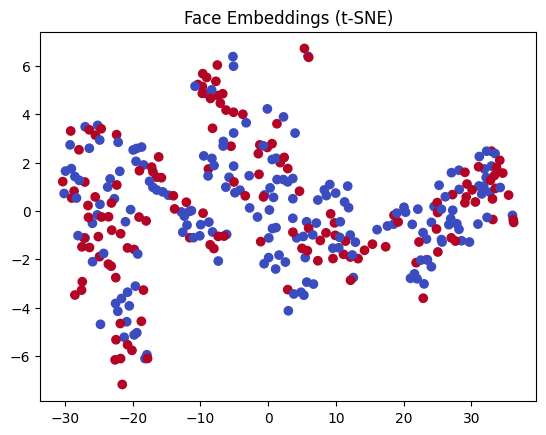

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings (add to eval)
embed_layer = best_model.get_layer('embedding_enhanced')  # Or 'embedding'
all_embeds = []
for batch in test_data:
    anchor, positive, _ = batch
    a_emb = embed_layer(anchor, training=False).numpy()
    p_emb = embed_layer(positive, training=False).numpy()
    all_embeds.extend(a_emb); all_embeds.extend(p_emb)
all_embeds = np.array(all_embeds)

tsne = TSNE(n_components=2, random_state=42)
embeds_2d = tsne.fit_transform(all_embeds)
plt.scatter(embeds_2d[:,0], embeds_2d[:,1], c=all_labels.repeat(2), cmap='coolwarm')
plt.title('Face Embeddings (t-SNE)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions: Matches=13/16, True matches=6

📊 Metrics on Test Batch:
   Precision: 0.3846
   Recall: 0.8333
   TP: 5, FP: 8, TN: 2, FN: 1
   Accuracy: 0.4375


C:\Users\Dennis Wanjiku\AppData\Local\Temp\ipykernel_12028\3217623756.py:53: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Dennis Wanjiku\AppData\Local\Temp\ipykernel_12028\3217623756.py:53: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Projects\EDUFACE PROJECT\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Projects\EDUFACE PROJECT\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


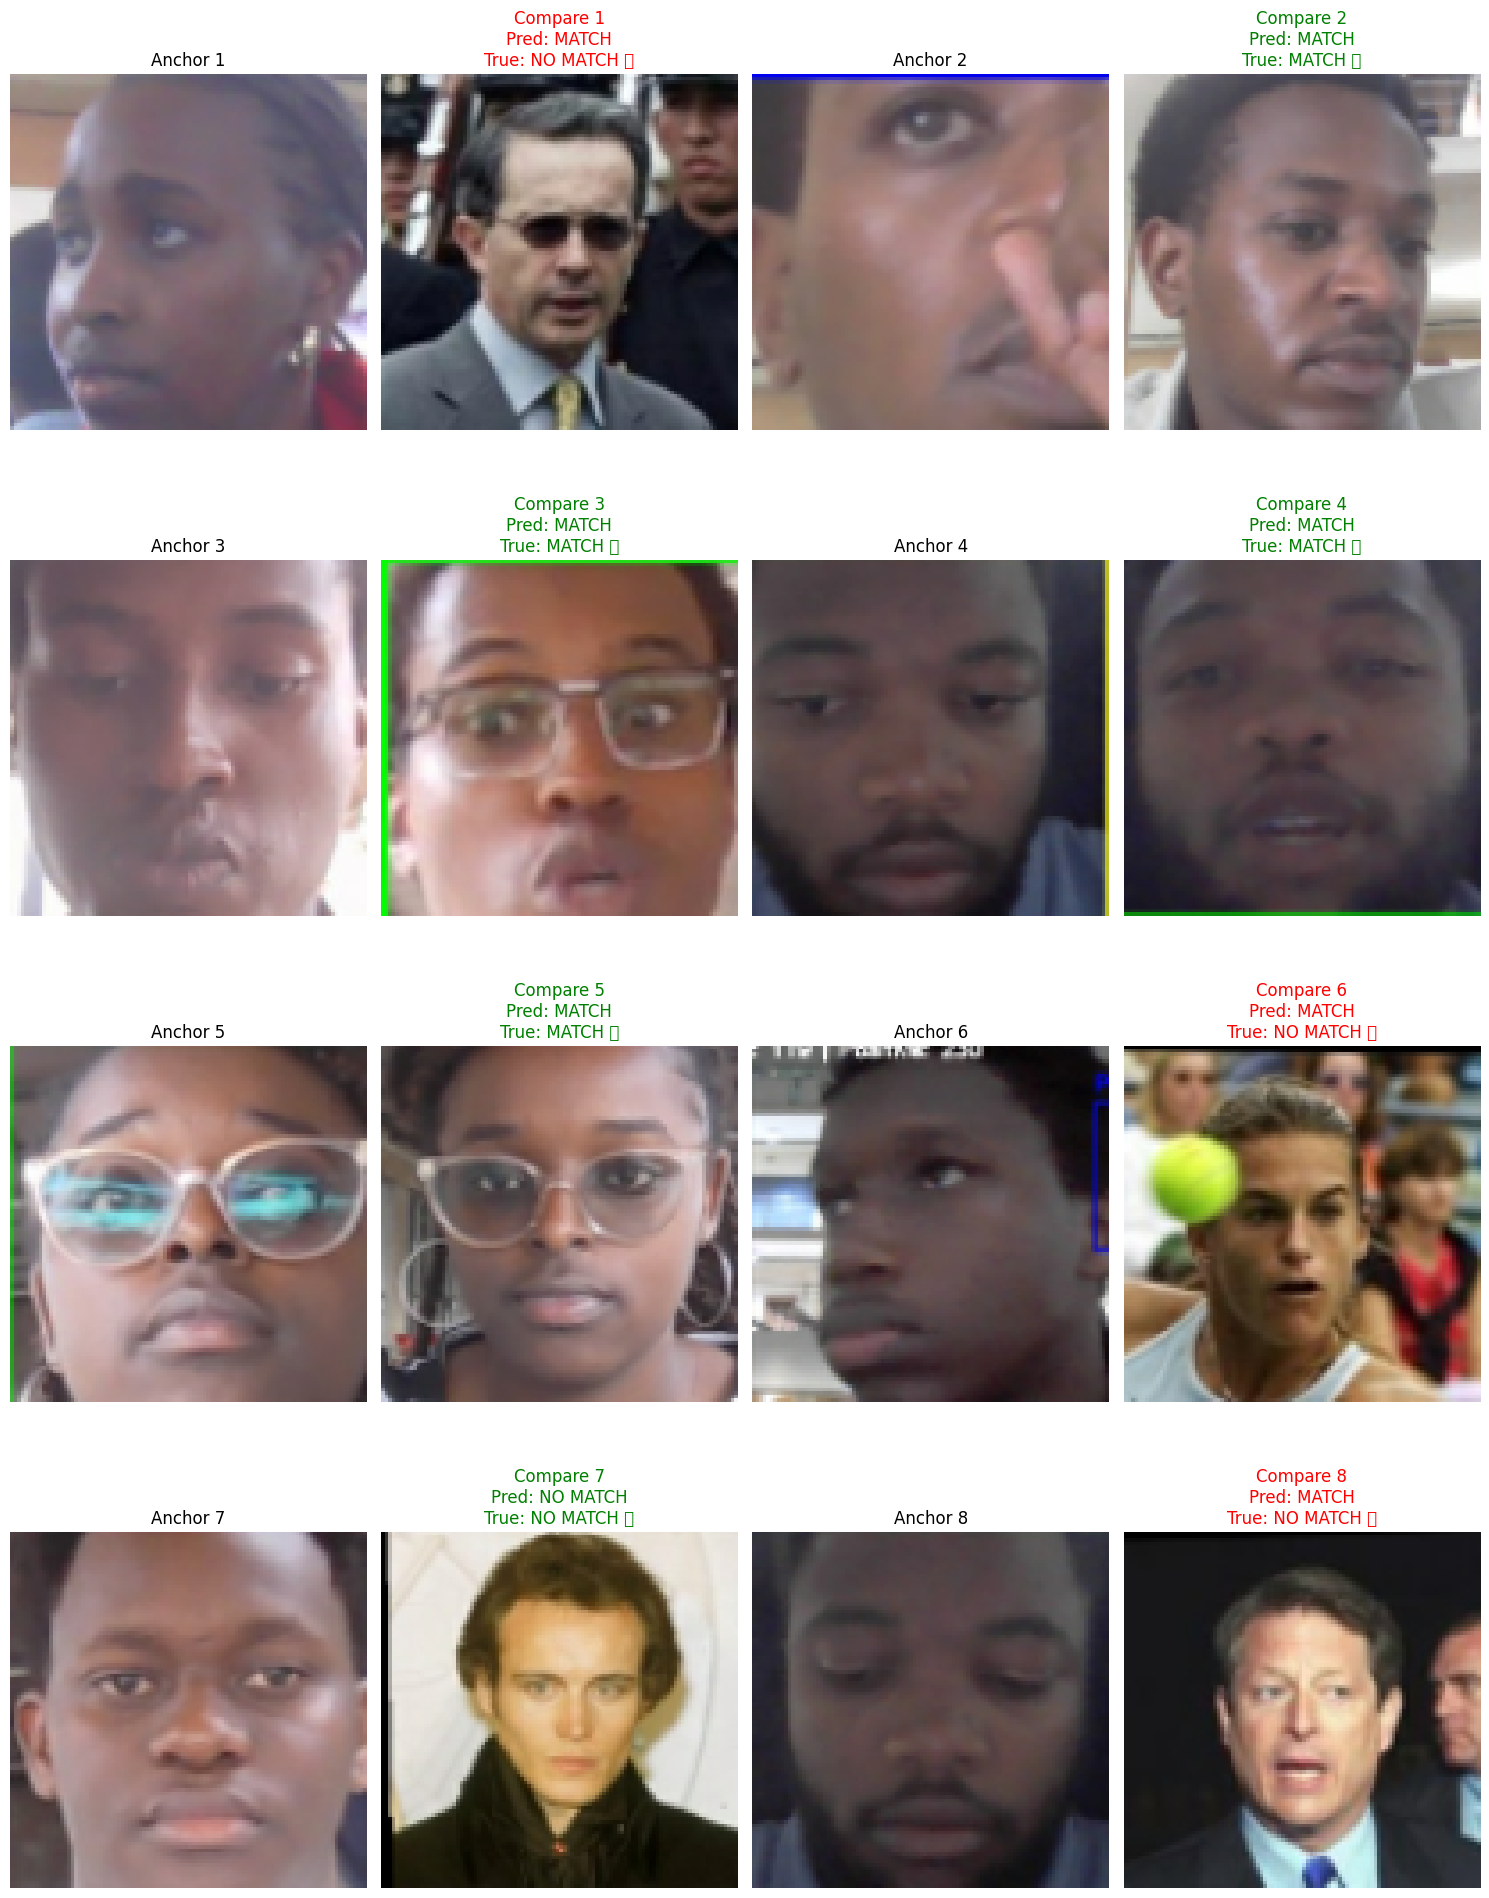

In [45]:
# ================================================
# 11. EVALUATE MODEL
# ================================================
# Test on one batch
try:
    test_batch = test_data.as_numpy_iterator().next()
    test_input, test_val, y_true = test_batch
    y_hat = siamese_model.predict([test_input, test_val])

    # Threshold predictions
    res = [1 if pred[0] > 0.5 else 0 for pred in y_hat]

    print(f"Predictions: Matches={sum(res)}/{len(res)}, True matches={int(sum(y_true))}")

    # Metrics
    recall = Recall()
    recall.update_state(y_true, tf.cast(res, tf.float32))
    precision = Precision()
    precision.update_state(y_true, tf.cast(res, tf.float32))

    print(f"\n📊 Metrics on Test Batch:")
    print(f"   Precision: {precision.result().numpy():.4f}")
    print(f"   Recall: {recall.result().numpy():.4f}")

    # Confusion Matrix
    tp = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 1)
    fp = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 1)
    tn = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 0)
    fn = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 0)

    print(f"   TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    accuracy = (tp + tn) / len(y_true)
    print(f"   Accuracy: {accuracy:.4f}")

    # Visualize Predictions
    n_vis = min(8, len(test_input))
    plt.figure(figsize=(15, 5 * ((n_vis + 1) // 2)))
    for i in range(n_vis):
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 1)
        plt.imshow(test_input[i])
        plt.title(f"Anchor {i+1}")
        plt.axis('off')
        
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 2)
        plt.imshow(test_val[i])
        pred = "MATCH" if res[i] == 1 else "NO MATCH"
        true = "MATCH" if y_true[i] == 1 else "NO MATCH"
        correct = "✅" if res[i] == y_true[i] else "❌"
        color = 'green' if res[i] == y_true[i] else 'red'
        plt.title(f"Compare {i+1}\nPred: {pred}\nTrue: {true} {correct}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
except StopIteration:
    print("No test data available for evaluation.")



In [13]:
# ================================================
# 12. SAVE MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
siamese_model.save(model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to C:\Projects\EDUFACE PROJECT\siamese_model.h5


In [14]:

# Load test
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded successfully.")

print("🎉 EDUFACE system ready for LMS integration!")

✅ Model loaded successfully.
🎉 EDUFACE system ready for LMS integration!


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Training Loss: ['0.7455', '0.7433', '0.7426', '0.7348', '0.7270', '0.7410', '0.7374', '0.7331', '0.7240', '0.7161', '0.7327', '0.7458', '0.7375', '0.7336', '0.7241', '0.7253', '0.7237', '0.7396', '0.7310', '0.7124', '0.7299', '0.7294', '0.7265', '0.7333', '0.7295', '0.7210']
Validation Loss: ['0.7049', '0.6970', '0.6917', '0.6953', '0.6998', '0.6635', '0.6853', '0.6932', '0.6269', '0.6511', '0.6563', '0.6757', '0.6414', '0.7078', '0.6496', '0.6158', '0.6732', '0.6724', '0.6737', '0.7632', '0.7984', '0.8199', '0.8478', '0.8436', '0.9128', '0.9205']


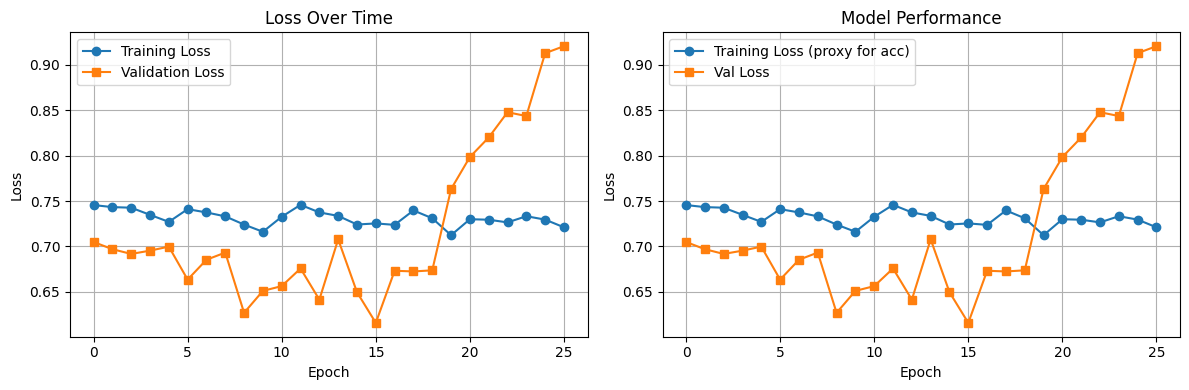


✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!


: 

In [ ]:
# Code to extract and print the training history data for the loss plot
# Run this after your training (where 'history' is defined from train() function)

import matplotlib.pyplot as plt
import numpy as np

# Print numerical values (easy to copy-paste)
print("Epochs:", list(range(1, len(history['loss']) + 1)))
print("Training Loss:", [f"{loss:.4f}" for loss in history['loss']])
print("Validation Loss:", [f"{val:.4f}" for val in history['val_loss']])

# Optionally, regenerate and save the plot as PNG (if you have the env)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss (proxy for acc)', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=150, bbox_inches='tight')  # Saves to current dir
plt.show()

print("\n✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!")

In [ ]:
# ================================================
# PART 1: STUDENT REGISTRATION/ENROLLMENT - FIXED FILENAME
# ================================================
# Filename now: name_id_count_angle_uuid.jpg (angle after count → clean prefix)

import cv2
import os
import uuid
import time
import platform
import numpy as np
import re  # For prefix extraction

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)

# Helper: Get student groups and counts
def get_student_counts(path):
    images = [f for f in os.listdir(path) if f.lower().endswith('.jpg')]
    groups = {}
    messy_files = []  # Flag bad filenames
    for img in images:
        # FIXED: Robust match for new format: name_id_count_angle_uuid
        match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_\d+_[a-z]+_[a-z0-9]+\.jpg', img)
        if match:
            prefix = match.group(1)
            groups.setdefault(prefix, []).append(img)
        else:
            messy_files.append(img)
    counts = {prefix: len(imgs) for prefix, imgs in groups.items()}
    max_count = max(counts.values()) if counts else 0
    return counts, max_count, messy_files

# Pre-scan for balance
counts, max_count, messy = get_student_counts(VERIFICATION_PATH)
if messy:
    print(f"⚠️ Warning: {len(messy)} messy filenames detected. Delete and re-enroll!")
if counts:
    print(f"📊 Current students: {', '.join(f'{k}: {v}' for k, v in counts.items())}")
    suggested = max_count  # Or max_count + 5 for buffer
    print(f"💡 Suggested target: {suggested} (matches max for balance)")
else:
    suggested = 10
    print("💡 No students yet—starting with 10.")

# Get student details (credentials collection)
student_name = input("Enter new student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')
target_input = input(f"How many images to capture? (Suggested: {suggested}, Recommended: 15-20, mix front/sides): ") or str(suggested)
target_images = int(target_input)

# Check existing for this student
prefix = f"{student_name}_{student_id}"
existing_count = counts.get(prefix, 0)
to_capture = max(0, target_images - existing_count)
if existing_count > 0:
    print(f"🔄 Re-enrolling {prefix}: {existing_count} existing → capturing {to_capture} more (total {target_images}).")
else:
    print(f"\n📁 Enrolling new {prefix} - Saving to {VERIFICATION_PATH}")
    to_capture = target_images
print("🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.")

# Find working webcam
def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found!")

# Load multiple Haar Cascades for full coverage
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

captured = 0
is_capturing = False
total_target = to_capture  # For display

try:
    while captured < to_capture:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        # Draw rectangles if faces detected
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)  # Red if multiple
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Captured: {captured}/{total_target} (Total goal: {target_images}) | Turn for profiles!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        status = "CAPTURING (Space to toggle) | Press 'Q' to quit" if is_capturing else "PAUSED - Press Space to start"
        cv2.putText(frame, status, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow(f"EDUFACE Enrollment - {student_name}_{student_id}", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # Space to toggle capture
            is_capturing = not is_capturing
            print(f"{'Started' if is_capturing else 'Stopped'} capturing")
        elif key == ord('q'):
            break

        # Auto-capture if face detected and capturing mode on
        if is_capturing and num_faces == 1 and captured < to_capture:
            (x, y, w, h) = faces[0]
            # Better centered crop
            center_x, center_y = x + w//2, y + h//2
            crop_size = min(w, h) * 1.2  # Slightly larger for context
            half = crop_size // 2
            face_crop = frame[max(0, int(center_y - half)):min(frame.shape[0], int(center_y + half)),
                              max(0, int(center_x - half)):min(frame.shape[1], int(center_x - half))]
            if face_crop.size > 0:  # Ensure not empty
                resized = cv2.resize(face_crop, (250, 250))
            else:
                resized = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
            
            unique_id = str(uuid.uuid4())[:8]
            ft = face_types[0] if len(face_types) > 0 else 'frontal'
            # FIXED: name_id_count_angle_uuid (angle AFTER count)
            filename = f"{student_name}_{student_id}_{ft}_{anchor_count}_{unique_id}.jpg"
            filepath = os.path.join(VERIFICATION_PATH, filename)
            cv2.imwrite(filepath, resized)
            print(f"✅ Enrolled image {existing_count + captured + 1}/{target_images}: {filename} (angle: {ft})")
            
            captured += 1
            time.sleep(1)  # Pause for variation

finally:
    cap.release()
    cv2.destroyAllWindows()

# Print credentials summary after enrollment
total_for_student = existing_count + captured
print(f"\n🎉 Enrollment complete for Student: {student_name.replace('_', ' ')} (ID: {student_id})!")
print(f"   📁 Total images saved: {total_for_student} in {VERIFICATION_PATH}")
print("💡 Re-run to verify balance. Now test verification!")

⚠️ Warning: 20 messy filenames detected. Delete and re-enroll!
📊 Current students: 150166_130293: 15, Barasa_Conslata_Nanzala_151097: 11, cate_150911: 9, Fidel_151168: 11, Tiffany_150364: 10
💡 Suggested target: 15 (matches max for balance)

📁 Enrolling new Maximillian_150651 - Saving to C:\Projects\EDUFACE PROJECT\verification_images
🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
Started capturing
✅ Enrolled image 1/15: Maximillian_150651_1_frontal_39916a3d.jpg (angle: frontal)
✅ Enrolled image 2/15: Maximillian_150651_2_profile_7563f02d.jpg (angle: profile)
✅ Enrolled image 3/15: Maximillian_150651_3_profile_2162e13d.jpg (angle: profile)
✅ Enrolled image 4/15: Maximillian_150651_4_frontal_alt_8b0e8770.jpg (angle: frontal_alt)
✅ Enrolled image 5/15: Maximillian_150651_5_frontal_3ea57109.jpg (angle: frontal)
✅ Enrolled im

In [ ]:
# ================================================
# PART 2: DAILY ATTENDANCE VERIFICATION - FULLY CORRECTED
# ================================================
# Features:
# - Loads enhanced finetuned model with dropout
# - Robust "Student Not Found" handling
# - Confidence thresholds for uncertain cases
# - Complete error handling

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dropout, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from datetime import datetime
from collections import defaultdict

# ================================================
# 1. DEFINE CUSTOM LAYERS
# ================================================
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
    def get_config(self):
        return super().get_config()

# Recreate enhanced embedding (MUST match training architecture)
def make_enhanced_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu', name='conv1')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool1')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu', name='conv2')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool2')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu', name='conv3')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool3')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu', name='conv4')(m3)
    f1 = tf.keras.layers.Flatten(name='flatten')(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid', name='dense')(f1)
    d_drop = Dropout(0.3, name='dropout')(d1)
    return tf.keras.Model(inputs=inp, outputs=d_drop, name='embedding_enhanced')

# ================================================
# 2. SETUP PATHS
# ================================================
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_image')
os.makedirs(INPUT_PATH, exist_ok=True)

# ================================================
# 3. LOAD ENHANCED MODEL WITH ALL CUSTOM OBJECTS
# ================================================
best_model_path = os.path.join(BASE_PATH, 'finetune_checkpoints', 'best_finetuned_siamese.h5')

# Complete custom objects dictionary
custom_objects = {
    'L1Dist': L1Dist,
    'RandomFlip': RandomFlip,
    'RandomRotation': RandomRotation,
    'RandomZoom': RandomZoom,
    'RandomBrightness': RandomBrightness,
    'RandomContrast': RandomContrast,
    'Dropout': Dropout
}

print("🔄 Loading enhanced finetuned model...")
try:
    loaded_model = load_model(best_model_path, custom_objects=custom_objects)
    print("✅ Enhanced model loaded successfully!")
    
    # DIAGNOSTIC: Verify model structure
    print(f"\n📊 Model Info:")
    print(f"   Total layers: {len(loaded_model.layers)}")
    has_dropout = any('dropout' in layer.name for layer in loaded_model.layers)
    print(f"   Has dropout: {'✅ YES' if has_dropout else '❌ NO (using old model!)'}")
    
    try:
        embedding_layer = loaded_model.get_layer('embedding_enhanced')
        print(f"   Embedding type: ✅ ENHANCED (with regularization)")
    except:
        try:
            embedding_layer = loaded_model.get_layer('embedding')
            print(f"   Embedding type: ⚠️ BASIC (no dropout)")
        except:
            print(f"   Embedding type: ❌ NOT FOUND")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("\n💡 Solutions:")
    print("   1. Check if file exists at:", best_model_path)
    print("   2. Re-run finetuning notebook to generate model")
    print("   3. Try loading .keras format instead of .h5")
    raise

# ================================================
# 4. PREPROCESSING FUNCTION
# ================================================
def preprocess_py(path, is_training=False):
    """Preprocess image for model input (matches training pipeline)"""
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    
    if is_training:
        # Training augmentation (not used in verification)
        img = tf.image.random_crop(img, [90, 90, 3])
        img = tf.image.random_flip_left_right(img)
    else:
        # Fixed center crop for consistent inference
        h, w = 100, 100
        crop_h, crop_w = 90, 90
        start_y = (h - crop_h) // 2
        start_x = (w - crop_w) // 2
        img = tf.image.crop_to_bounding_box(img, start_y, start_x, crop_h, crop_w)
    
    img = tf.image.resize(img, (100, 100))
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

# ================================================
# 5. STUDENT GROUPING FUNCTIONS
# ================================================
def get_student_prefix(filename):
    """Extract student identifier (name_id) from filename"""
    basename = os.path.splitext(filename)[0]
    parts = basename.split('_', 2)  # Split at most twice
    if len(parts) >= 2:
        return '_'.join(parts[:2])  # e.g., 'john_doe_12345' -> 'john_doe_12345'
    return 'unknown'

def split_credentials(prefix):
    """Split prefix into name and ID"""
    if prefix == 'unknown' or '_' not in prefix:
        return None, None
    name, id_ = prefix.rsplit('_', 1)  # Split once from right
    return name.replace('_', ' ').title(), id_  # Restore spaces and title case

def merge_student_groups(all_images):
    """Group images by student prefix (handles duplicate angles)"""
    groups = defaultdict(list)
    for image in all_images:
        prefix = get_student_prefix(image)
        if prefix != 'unknown':
            groups[prefix].append(image)
    return dict(groups)

# ================================================
# 6. LOAD HAAR CASCADES FOR FACE DETECTION
# ================================================
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    """Detect faces using multiple cascades for better coverage"""
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    """Remove overlapping face detections using IoU"""
    if len(faces) <= 1:
        return faces, types
    
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]:
            continue
        for j in range(i+1, len(faces)):
            if not keep[j]:
                continue
            
            # Calculate IoU
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            
            if iou > threshold:
                # Keep larger face
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    
    return [faces[i] for i in range(len(faces)) if keep[i]], \
           [types[i] for i in range(len(types)) if keep[i]]

# ================================================
# 7. VERIFICATION FUNCTION - WITH "NOT FOUND" HANDLING
# ================================================
def verify(model, detection_threshold=0.5, verification_threshold=0.35, uncertain_threshold=0.25):
    """
    Verify student identity with three-tier confidence system:
    - verification_threshold (0.452): Strong match
    - uncertain_threshold (0.35): Uncertain/borderline
    - Below uncertain: Student not found
    """
    verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    if not verification_images:
        print("⚠️ No enrolled images found in database!")
        return None, None, None, [], False, "NO_DATABASE"
    
    input_img_path = os.path.join(INPUT_PATH, 'input_image.jpg')
    if not os.path.exists(input_img_path):
        print("⚠️ No input image captured!")
        return None, None, None, [], False, "NO_INPUT"
    
    # Load and preprocess input image
    input_img = preprocess_py(input_img_path, is_training=False)
    
    # Group students
    student_groups = merge_student_groups(verification_images)
    print(f"\n🔍 Searching {len(student_groups)} enrolled students...")
    
    if not student_groups:
        print("⚠️ No valid student groups found!")
        return None, None, None, [], False, "NO_VALID_GROUPS"
    
    # Compute similarity scores for each student
    student_scores = {}
    all_results = []
    
    for student_prefix, images in student_groups.items():
        results = []
        for image in images:
            val_img_path = os.path.join(VERIFICATION_PATH, image)
            val_img = preprocess_py(val_img_path, is_training=False)
            
            # Predict similarity
            batched_input = np.expand_dims(input_img, axis=0)
            batched_val = np.expand_dims(val_img, axis=0)
            result = model.predict([batched_input, batched_val], verbose=0)[0][0]
            
            results.append(result)
            all_results.append(result)
        
        if results:
            # Use median for robustness against outliers
            median_score = np.median(results)
            student_scores[student_prefix] = median_score
    
    if not student_scores:
        print("⚠️ No scores computed!")
        return None, None, None, [], False, "NO_SCORES"
    
    # Find best match
    best_prefix = max(student_scores, key=student_scores.get)
    best_score = student_scores[best_prefix]
    best_name, best_id = split_credentials(best_prefix)
    
    print(f"\n📊 Top Match: {best_name or best_prefix} (ID: {best_id}) - Score: {best_score:.3f}")
    
    # THREE-TIER DECISION SYSTEM
    if best_score >= verification_threshold:
        # STRONG MATCH
        print(f"✅ VERIFIED: {best_name} (ID: {best_id}) - High Confidence: {best_score:.2f}")
        return best_prefix, best_name, best_id, all_results, True, "VERIFIED"
    
    elif best_score >= uncertain_threshold:
        # UNCERTAIN/BORDERLINE
        print(f"⚠️ UNCERTAIN MATCH: {best_name or best_prefix} (Score: {best_score:.2f})")
        print(f"   Confidence too low. Possible reasons:")
        print(f"   - Poor lighting or angle")
        print(f"   - Face partially obscured")
        print(f"   - Need more enrollment images")
        return best_prefix, best_name, best_id, all_results, False, "UNCERTAIN"
    
    else:
        # STUDENT NOT FOUND
        print(f"❌ STUDENT NOT FOUND IN DATABASE")
        print(f"   Highest similarity: {best_score:.2f} (too low)")
        print(f"   This person is likely not enrolled.")
        print(f"   → Action: Enroll this student first!")
        return None, None, None, all_results, False, "NOT_FOUND"

# ================================================
# 8. LIVE WEBCAM VERIFICATION LOOP
# ================================================
print("\n" + "="*60)
print("🎓 EDUFACE - CLASS ATTENDANCE SYSTEM")
print("="*60)
print("📋 Enrolled Students:")
all_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
merged_groups = merge_student_groups(all_images)
for i, (prefix, images) in enumerate(merged_groups.items(), 1):
    name, sid = split_credentials(prefix)
    print(f"   {i}. {name} (ID: {sid}) - {len(images)} images")
print("="*60)

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise ValueError("❌ No webcam detected!")

print("\n🎥 Webcam Active")
print("   Controls:")
print("   - Press 'V' to verify attendance (when 1 face detected)")
print("   - Press 'Q' to quit")
print("\n💡 Tips:")
print("   - Face camera directly with good lighting")
print("   - Remove glasses/hats if possible")
print("   - Wait for GREEN box around your face")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ Failed to read from webcam")
            break
        
        # Detect faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)
        
        # Draw face boxes
        colors = {
            'frontal': (0, 255, 0),      # Green
            'profile': (255, 0, 0),       # Blue
            'frontal_alt': (0, 255, 255), # Yellow
            'frontal_alt2': (255, 0, 255) # Magenta
        }
        
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            # Use red if multiple faces (invalid for verification)
            color = colors.get(ft, (0, 255, 0)) if num_faces == 1 else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 3)
            
            # Label face type
            label = ft.replace('_', ' ').title()
            cv2.putText(frame, label, (x, y - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        # Status display
        if num_faces == 0:
            status = "No face detected"
            status_color = (0, 0, 255)  # Red
        elif num_faces == 1:
            status = "Ready - Press 'V' to verify"
            status_color = (0, 255, 0)  # Green
        else:
            status = f"Multiple faces ({num_faces}) - Only 1 allowed"
            status_color = (0, 0, 255)  # Red
        
        cv2.putText(frame, status, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
        
        # Instructions
        cv2.putText(frame, "V: Verify | Q: Quit", (10, frame.shape[0] - 20),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        cv2.imshow('EDUFACE - Class Attendance', frame)
        
        # Handle key presses
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('v') or key == ord('V'):
            if num_faces == 1:
                # Capture and crop face
                (x, y, w, h) = faces[0]
                
                # Better centered crop
                center_x, center_y = x + w//2, y + h//2
                crop_size = int(min(w, h) * 1.2)
                half = crop_size // 2
                
                y_start = max(0, center_y - half)
                y_end = min(frame.shape[0], center_y + half)
                x_start = max(0, center_x - half)
                x_end = min(frame.shape[1], center_x + half)
                
                face_crop = frame[y_start:y_end, x_start:x_end]
                
                if face_crop.size > 0:
                    resized_crop = cv2.resize(face_crop, (250, 250))
                else:
                    resized_crop = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
                
                cv2.imwrite(os.path.join(INPUT_PATH, 'input_image.jpg'), resized_crop)
                print("\n📸 Face captured - Verifying...")
                
                # Verify identity
                best_prefix, best_name, best_id, results, verified, status_code = verify(loaded_model)
                
                # Handle different outcomes
                if status_code == "VERIFIED":
                    # SUCCESSFUL VERIFICATION
                    avg_conf = np.mean([s for s in results if s > 0.452])
                    attendance_status = "PRESENT ✅"
                    
                    print(f"\n{'='*50}")
                    print(f"✅ {attendance_status}")
                    print(f"   Student: {best_name}")
                    print(f"   ID: {best_id}")
                    print(f"   Confidence: {avg_conf:.2%}")
                    print(f"{'='*50}")
                    
                    # Log to CSV
                    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_entry = f"{best_name},{best_id},{attendance_status},{avg_conf:.4f},{timestamp}"
                    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
                    
                    # Create/append to CSV
                    file_exists = os.path.exists(log_file) and os.path.getsize(log_file) > 0
                    with open(log_file, 'a', encoding='utf-8') as f:
                        if not file_exists:
                            f.write("StudentName,StudentID,Status,Confidence,Timestamp\n")
                        f.write(log_entry + '\n')
                    
                    print(f"📝 Attendance logged to: {log_file}")
                
                elif status_code == "UNCERTAIN":
                    # BORDERLINE CASE
                    print(f"\n{'='*50}")
                    print(f"⚠️ VERIFICATION UNCERTAIN")
                    print(f"   Possible match: {best_name} (ID: {best_id})")
                    print(f"   Confidence too low for automatic attendance")
                    print(f"   → Try again with better lighting/angle")
                    print(f"   → Or manually verify this student")
                    print(f"{'='*50}")
                
                elif status_code == "NOT_FOUND":
                    # STUDENT NOT IN DATABASE
                    print(f"\n{'='*50}")
                    print(f"❌ STUDENT NOT FOUND")
                    print(f"   This face is not in the enrollment database")
                    print(f"   → Please enroll this student first")
                    print(f"   → Run the enrollment script (Part 1)")
                    print(f"{'='*50}")
                    
                    # Optional: Log unknown attempts
                    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_entry = f"UNKNOWN,N/A,NOT FOUND,0.0000,{timestamp}"
                    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
                    
                    file_exists = os.path.exists(log_file) and os.path.getsize(log_file) > 0
                    with open(log_file, 'a', encoding='utf-8') as f:
                        if not file_exists:
                            f.write("StudentName,StudentID,Status,Confidence,Timestamp\n")
                        f.write(log_entry + '\n')
                
                else:
                    # OTHER ERRORS
                    print(f"\n⚠️ Verification error: {status_code}")
            
            else:
                print(f"\n⚠️ Need exactly 1 face for verification ({num_faces} detected)")
                print("   → Ensure only one person is in frame")
        
        elif key == ord('q') or key == ord('Q'):
            print("\n👋 Exiting class session...")
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("\n✅ Class session complete!")
    print(f"📊 Check attendance log: {os.path.join(BASE_PATH, 'class_attendance.csv')}")

🔄 Loading enhanced finetuned model...


✅ Enhanced model loaded successfully!

📊 Model Info:
   Total layers: 5
   Has dropout: ❌ NO (using old model!)
   Embedding type: ✅ ENHANCED (with regularization)
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade

🎓 EDUFACE - CLASS ATTENDANCE SYSTEM
📋 Enrolled Students:
   1. 150166 (ID: 130293) - 15 images
   2. Barasa (ID: Conslata) - 15 images
   3. Cate (ID: 150911) - 15 images
   4. Fidel (ID: 151168) - 16 images
   5. Maximillian (ID: 150651) - 15 images
   6. Tiffany (ID: 150364) - 15 images

🎥 Webcam Active
   Controls:
   - Press 'V' to verify attendance (when 1 face detected)
   - Press 'Q' to quit

💡 Tips:
   - Face camera directly with good lighting
   - Remove glasses/hats if possible
   - Wait for GREEN box around your face

⚠️ Need exactly 1 face for verification (0 detected)
   → Ensure only one person is in frame

⚠️ Need exactly 1 face for verification (0 detected)
   → Ensure only one person is in frame

📸 F